## 1. Импорт библиотек

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import torch

c:\Tasks\codegen\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Загрузка датасета CodeSearchNet (Python)

In [2]:
dataset = load_dataset("code_search_net", "python")

## 3. Предобработка данных: описание и код

In [3]:
def preprocess(example):
    return {
        "input_text": example["func_documentation_string"],
        "target_text": example["func_code_string"]
    }

dataset = dataset.map(preprocess)
dataset = dataset["train"].train_test_split(test_size=0.1)
train_data = dataset["train"]
eval_data = dataset["test"]


In [4]:
# Ограничиваем размер выборки
train_data = train_data.shuffle(seed=42).select(range(10000))
eval_data = eval_data.shuffle(seed=42).select(range(1000))


## 4. Загрузка токенизатора и модели CodeT5-small

In [5]:
model_checkpoint = "Salesforce/codet5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [5]:
model_checkpoint = "./codet5-finetuned-python/checkpoint-15000"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

## 5. Токенизация данных

In [6]:
MAX_INPUT = 256
MAX_TARGET = 256

def tokenize(example):
    model_input = tokenizer(example["input_text"], padding="max_length", truncation=True, max_length=MAX_INPUT)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["target_text"], padding="max_length", truncation=True, max_length=MAX_TARGET)
    model_input["labels"] = labels["input_ids"]
    return model_input

train_data = train_data.map(tokenize, batched=True)
eval_data = eval_data.map(tokenize, batched=True)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]c:\Tasks\codegen\.venv\lib\site-packages\transformers\tokenization_utils_base.py:3970: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 1000/1000 [00:00<00:00, 1622.99 examples/s]


## 6. Настройка параметров обучения

In [7]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./codet5-finetuned-python",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=9,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
)

c:\Tasks\codegen\.venv\lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 7. Метрика качества (BLEU)

In [8]:
bleu = evaluate.load("bleu")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return bleu.compute(predictions=decoded_preds, references=[[l] for l in decoded_labels])

## 8. Обучение модели

In [9]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\Viktor\AppData\Local\Temp\ipykernel_19836\3448982200.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.train()

C:\Users\Viktor\AppData\Local\Temp\ipykernel_17332\2903914459.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Precisions,Brevity Penalty,Length Ratio,Translation Length,Reference Length
1,1.063800,1.005253,0.000192,"[0.734113328745125, 0.3832440983207593, 0.2744882093806686, 0.20843724023275145]",0.000539,0.117293,17436,148654
2,1.014300,0.963677,0.000264,"[0.7656894311698582, 0.4598575106268335, 0.3514615041711775, 0.27933074882677006]",0.000613,0.119089,17703,148654
3,0.975000,0.952530,0.000259,"[0.7763440860215054, 0.46124775044991, 0.34779834077855776, 0.27389229720518066]",0.000603,0.118867,17670,148654


TrainOutput(global_step=7500, training_loss=1.0862274698893228, metrics={'train_runtime': 24461.4254, 'train_samples_per_second': 1.226, 'train_steps_per_second': 0.307, 'total_flos': 2030127022080000.0, 'train_loss': 1.0862274698893228, 'epoch': 3.0})

In [13]:
trainer.train(resume_from_checkpoint="./codet5-finetuned-python/checkpoint-7500")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Precisions,Brevity Penalty,Length Ratio,Translation Length,Reference Length
4,0.999700,0.890121,0.000379,"[0.7878601053693532, 0.49311245695285594, 0.38284307536927153, 0.30251987602748953]",0.000823,0.123413,17842,144572
5,0.968100,0.880511,0.000359,"[0.7890243217435263, 0.4799143010176754, 0.3635385686262102, 0.2825103019658177]",0.000808,0.123143,17803,144572
6,0.951300,0.877469,0.000362,"[0.7910145253912848, 0.49021596468201883, 0.37577718563634055, 0.2962335726866278]",0.000793,0.122859,17762,144572


TrainOutput(global_step=15000, training_loss=0.492298828125, metrics={'train_runtime': 23872.9882, 'train_samples_per_second': 2.513, 'train_steps_per_second': 0.628, 'total_flos': 4060254044160000.0, 'train_loss': 0.492298828125, 'epoch': 6.0})

In [10]:
trainer.train(resume_from_checkpoint="./codet5-finetuned-python/checkpoint-15000")

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Bleu,Precisions,Brevity Penalty,Length Ratio,Translation Length,Reference Length
7,0.971700,0.853929,0.000316,"[0.8030680403034077, 0.5063002520100804, 0.3916124090386825, 0.31065048411291424]",0.000671,0.120374,17666,146759
8,0.964900,0.848032,0.000336,"[0.8168076706147772, 0.5246861924686193, 0.4053401144310235, 0.3219959266802444]",0.000691,0.120810,17730,146759
9,0.965500,0.845839,0.000342,"[0.8119586005174936, 0.5212778638693527, 0.40436050196476103, 0.321897415076465]",0.000707,0.121137,17778,146759


TrainOutput(global_step=22500, training_loss=0.32374851481119793, metrics={'train_runtime': 25463.2718, 'train_samples_per_second': 3.535, 'train_steps_per_second': 0.884, 'total_flos': 6090381066240000.0, 'train_loss': 0.32374851481119793, 'epoch': 9.0})

## 9. Сохранение модели

In [14]:
trainer.save_model("./codet5-finetuned-python")
tokenizer.save_pretrained("./codet5-finetuned-python")

## 10. Загрузка модели для инференса

In [10]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_path = "./codet5-finetuned-python/checkpoint-15000"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

## 11. Генерация кода по описанию

In [11]:
def generate_code(description, max_length=256):
    inputs = tokenizer(description, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model.generate(**inputs, max_length=max_length, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [17]:
description = """Get factorial of a number."""
generated_code = generate_code(description)
print("Generated code:\n", generated_code)

Generated code:
 def factorial(self, number):
        """Get factorial of a number."""
        if not isinstance(number, int):
            raise TypeError("Number must be a integer")
        return self.factorial_factor(number)


## 12. Визуализация

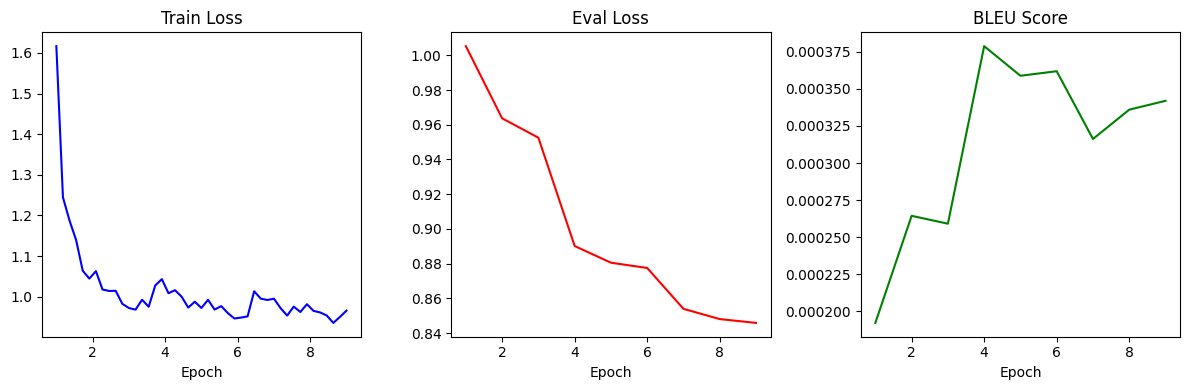

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np

state_path = "./codet5-finetuned-python/checkpoint-22500/trainer_state.json"

with open(state_path, "r") as f:
    trainer_state = json.load(f)

logs = trainer_state["log_history"]

train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
bleu_score = [log["eval_bleu"] for log in logs if "eval_bleu" in log]
epochs = [log["epoch"] for log in logs if "epoch" in log]

bleu_score = [score for score in bleu_score if score is not None]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(np.linspace(1,9,len(train_loss)), train_loss, color="blue")
plt.title("Train Loss")
plt.xlabel("Epoch")

plt.subplot(1, 3, 2)
plt.plot(np.linspace(1,9,len(eval_loss)), eval_loss, color="red")
plt.title("Eval Loss")
plt.xlabel("Epoch")

plt.subplot(1, 3, 3)
plt.plot(np.linspace(1,9,len(bleu_score)), bleu_score, color="green")
plt.title("BLEU Score")
plt.xlabel("Epoch")

plt.tight_layout()
plt.show()



# 13. Сравнительный анализ

In [1]:
from datasets import load_dataset

dataset = load_dataset("code_search_net", "python", split="validation[:100]")

test_samples = [
    {"input": sample["func_code_string"], "target": sample["func_documentation_string"]}
    for sample in dataset
    if sample["func_documentation_string"]
]

c:\Tasks\codegen\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from evaluate import load
import torch

bleu = load("bleu")
rouge = load("rouge")
meteor = load("meteor")

def evaluate_model(model_id, is_seq2seq=True, max_len=128):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model_cls = AutoModelForSeq2SeqLM if is_seq2seq else AutoModelForCausalLM
    model = model_cls.from_pretrained(model_id).to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id

    preds, refs = [], []

    for sample in test_samples:
        inputs = tokenizer(sample["input"], return_tensors="pt", truncation=True, padding=True, max_length=512).to(model.device)
        with torch.no_grad():
            output = model.generate(**inputs, max_new_tokens=max_len, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
        decoded = tokenizer.decode(output[0], skip_special_tokens=True)
        preds.append(decoded)
        refs.append([sample["target"]])

    results = {
        "bleu": bleu.compute(predictions=preds, references=refs)["bleu"],
        "rougeL": rouge.compute(predictions=preds, references=refs)["rougeL"],
        "meteor": meteor.compute(predictions=preds, references=refs)["meteor"]
    }

    return results

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Viktor\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Viktor\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Viktor\AppData\Roaming\nltk_data...


In [4]:
import json

models_to_compare = {
    "CodeT5-finetuned (7500)": ("./codet5-finetuned-python/checkpoint-7500", True),
    "CodeT5-finetuned (15000)": ("./codet5-finetuned-python/checkpoint-15000", True),
    "CodeT5-finetuned (22500)": ("./codet5-finetuned-python/checkpoint-22500", True),
    "CodeT5-small": ("Salesforce/codet5-small", True),
    "GPT-2": ("gpt2", False),
    "CodeGen-350M": ("Salesforce/codegen-350M-mono", False),
}

results = {}

for name, (model_id, is_seq2seq) in models_to_compare.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model_id, is_seq2seq=is_seq2seq)
    results[name] = metrics
    print(f"{name} scores: {metrics}")

with open("evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)


Evaluating CodeT5-finetuned (7500)...
CodeT5-finetuned (7500) scores: {'bleu': 0.34150655204797553, 'rougeL': np.float64(0.47463414623368233), 'meteor': np.float64(0.577969466161058)}
Evaluating CodeT5-finetuned (15000)...
CodeT5-finetuned (15000) scores: {'bleu': 0.32546492417834616, 'rougeL': np.float64(0.4656016295295784), 'meteor': np.float64(0.5680727407162147)}
Evaluating CodeT5-finetuned (22500)...
CodeT5-finetuned (22500) scores: {'bleu': 0.3223315969550678, 'rougeL': np.float64(0.4628846850063653), 'meteor': np.float64(0.5627180808758978)}
Evaluating CodeT5-small...
CodeT5-small scores: {'bleu': 0.01256703290555514, 'rougeL': np.float64(0.06793646068935011), 'meteor': np.float64(0.030802400823742495)}
Evaluating GPT-2...
GPT-2 scores: {'bleu': 0.23481455944397236, 'rougeL': np.float64(0.36786449538160837), 'meteor': np.float64(0.5252309068371303)}
Evaluating CodeGen-350M...


Some weights of the model checkpoint at Salesforce/codegen-350M-mono were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (e

CodeGen-350M scores: {'bleu': 0.24401231533319764, 'rougeL': np.float64(0.36074237713735113), 'meteor': np.float64(0.538991771416696)}


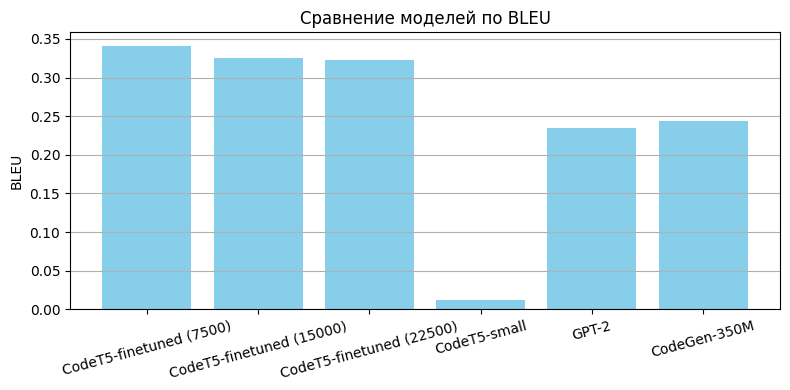

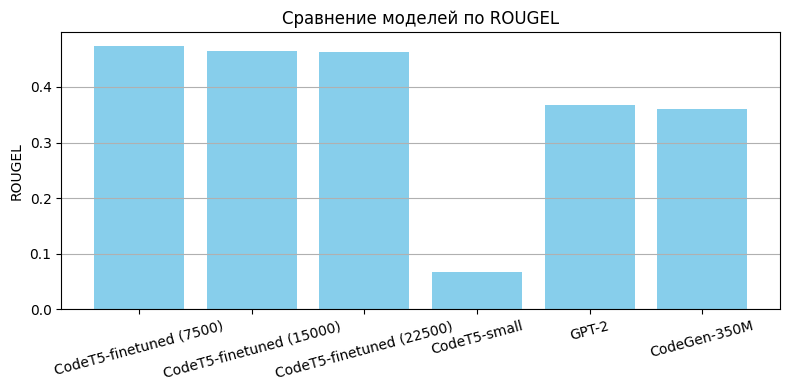

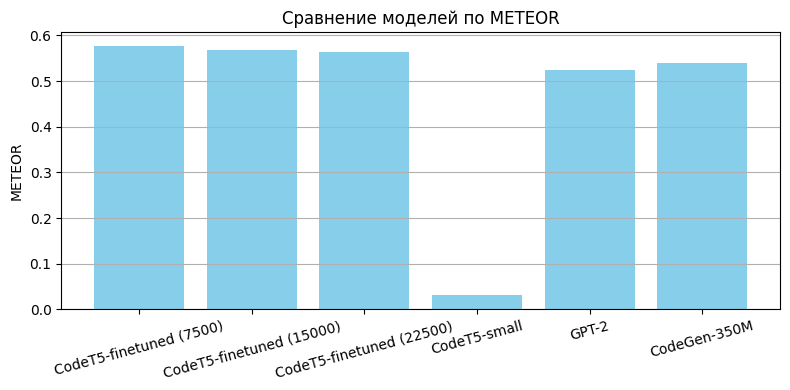

In [5]:
import matplotlib.pyplot as plt
import json

with open("evaluation_results.json", "r") as f:
    results = json.load(f)

metrics = ["bleu", "rougeL", "meteor"]

for metric in metrics:
    plt.figure(figsize=(8, 4))
    values = [results[model][metric] for model in results]
    plt.bar(results.keys(), values, color='skyblue')
    plt.ylabel(metric.upper())
    plt.title(f"Сравнение моделей по {metric.upper()}")
    plt.xticks(rotation=15)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()